In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from general_tools.notebook.tf import reset_tf_graph                                              
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances,\
                                     jensen_shannon_divergence, sample_pclouds_distances

from general_tools.strings import trim_content_after_last_dot

from general_tools.plotting import stack_images_in_square_grid

from tf_lab.nips.helper import pclouds_centered_and_half_sphere, zero_mean_half_sphere
import scipy.stats as stats

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
cmp_in_sphere = True
voxel_resolution = 28

In [6]:
class_name = 'chair'
ae_loss = 'emd'
cmp_jsd = True
save_figs = False
cmp_with_noise = False
cmp_mit = False

In [7]:
# Load Ground-Truth Data
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/gt_all_' + class_name + '.npz'
gt_data = np.load(in_f)
gt_data = gt_data[gt_data.keys()[0]]

if cmp_jsd:
    _, gt_grid_var = entropy_of_occupancy_grid(gt_data, voxel_resolution, in_sphere=cmp_in_sphere)

# JSD Measurements

In [8]:
# Compare JSD of GT with random noise.
if cmp_jsd and cmp_with_noise:
    mu, sigma = 0, 1
    lower = -0.5
    upper = 0.5
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    size = (len(gt_data), n_pc_samples, 3)
    random_pcs = X.rvs(np.prod(size))
    random_pcs = random_pcs.reshape(size)

    _, random_grid_var = entropy_of_occupancy_grid(random_pcs, voxel_resolution, in_sphere=cmp_in_sphere)
    print 'JSD with trunc-normal :', jensen_shannon_divergence(random_grid_var, gt_grid_var)
    
    lower = -0.5
    upper = 0.5
    random_pcs = np.random.uniform(low=lower, high=upper, size=(len(gt_data), n_pc_samples, 3))

    _, random_grid_var = entropy_of_occupancy_grid(random_pcs, voxel_resolution, in_sphere=cmp_in_sphere)
    print 'JSD with Uniform :', jensen_shannon_divergence(random_grid_var, gt_grid_var)

In [9]:
# AE - GAN
ae_tag = 'ae_' + ae_loss + '_' + class_name + '_' + str(n_pc_samples) + '_pts'
top_in = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/', ae_tag)
jsd_measurements = []
for epoch in range(1, 51):
    in_f = osp.join(top_in, 'epoch_' + str(epoch) + '.npz')
    our_data = np.load(in_f)
    our_data = our_data[our_data.keys()[0]]
    our_data = pclouds_centered_and_half_sphere(our_data)            
    _, our_grid_var = entropy_of_occupancy_grid(our_data, voxel_resolution, in_sphere=cmp_in_sphere)
    jsd_epoch = jensen_shannon_divergence(our_grid_var, gt_grid_var)
    jsd_measurements.append(jsd_epoch)
    print 'Our samples JSD:', jsd_epoch

Our samples JSD: 0.121429071989
Our samples JSD: 0.0596704567574
Our samples JSD: 0.0460678784089
Our samples JSD: 0.0320243783395
Our samples JSD: 0.0288383605831
Our samples JSD: 0.0299838555037
Our samples JSD: 0.0244943577945
Our samples JSD: 0.0331410387101
Our samples JSD: 0.023324573803
Our samples JSD: 0.0218907484686
Our samples JSD: 0.0219810317666
Our samples JSD: 0.021312978132
Our samples JSD: 0.0186582711143
Our samples JSD: 0.0213775953076
Our samples JSD: 0.0189602701274
Our samples JSD: 0.0139401413793
Our samples JSD: 0.0134712312968
Our samples JSD: 0.0145677067986
Our samples JSD: 0.0194958088427
Our samples JSD: 0.0191811161558
Our samples JSD: 0.0145060090396
Our samples JSD: 0.0154891175928
Our samples JSD: 0.0112241111948
Our samples JSD: 0.0187810198947
Our samples JSD: 0.0193863701376
Our samples JSD: 0.0161171460438
Our samples JSD: 0.0171709174928
Our samples JSD: 0.0174155383385
Our samples JSD: 0.0154802835504
Our samples JSD: 0.019818718154
Our samples JS

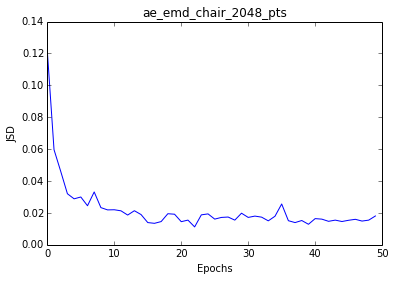

In [10]:
np.savez(osp.join(top_in, 'jsd_measurements'), np.array(jsd_measurements))
plt.title(ae_tag)
plt.xlabel('Epochs')
plt.ylabel('JSD')
plt.plot(range(len(jsd_measurements)), jsd_measurements)

In [39]:
if cmp_mit and cmp_jsd:
    in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/mit_3dgan_synthetic_samples/point_clouds/2048/'
    in_f = osp.join(in_f, '2K_models_per_class/'+ class_name + '.npz')

    mit_data = np.load(in_f)
    mit_data = mit_data[mit_data.keys()[0]]
    mit_data = pclouds_centered_and_half_sphere(mit_data)
    _, mit_grid_var = entropy_of_occupancy_grid(mit_data, voxel_resolution, in_sphere=cmp_in_sphere)

    print 'MIT JSD:', jensen_shannon_divergence(mit_grid_var, gt_grid_var)

MIT JSD: 0.261224217478


# Plotting data in grid

In [13]:
top_fig_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/images/' + ae_tag + '_'
top_fig_dir = create_dir(osp.join(top_fig_dir, ae_tag+'epoch_50'))
syn_data = our_data 
# FIx above

size = 500
rids = np.random.choice(range(len(syn_data)), size=size, replace=False)
plt.ioff()

for i in range(size):
    fig = Point_Cloud(syn_data[rids[i]]).plot(show=False, show_axis=False, azim=290, in_u_sphere=True, s=20);
    fig.savefig(osp.join(top_fig_dir, 'sample_' +str(i)))
    plt.close()

file_names = glob.glob(top_fig_dir +'/*.png')
stack_images_in_square_grid(file_names, save_file= osp.join(top_fig_dir, 'aggregate_samples.png'));
plt.ion()

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [14]:
# Pairwise Distances
# check_data = 
# distance_type = 'chamfer'
# all_dists = sample_pclouds_distances(check_data, 30, 100, distance_type)
# print np.mean(all_dists)